In [1]:
import wandb
import yaml
from utilities.utils import correct_type_of_entry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from copy import deepcopy
import seaborn as sn
pd.set_option('display.max_rows', None)

/Users/mathieubazinet/.pyenv/versions/3.12.3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [75]:
dataset = "powerplant"
sweep_config = "tree"
min_max_val = {'concrete':{'min_val':2.33, 'max_val':82.6},
               'parkinson':{'min_val':5.0377, 'max_val':39.511}, 
               'airfoil':{'min_val':103.38, 'max_val':140.987}, 
               'powerplant':{'min_val':420.26, 'max_val':495.76},
               'infrared':{'min_val':35.75, 'max_val':39.3}}
min_max_val_10_percent = {dts:{"min_val": max(0,min_max_val[dts]['min_val'] - 0.1*(min_max_val[dts]['max_val'] - min_max_val[dts]['min_val'])),
                              "max_val":min_max_val[dts]['max_val'] + 0.1*(min_max_val[dts]['max_val'] - min_max_val[dts]['min_val'])} for dts in min_max_val.keys()}
values_to_fetch = ['kl_bound', 'min_val_catoni_bound', 'compression_set_size', 'complement_loss', 'validation_loss', 'test_loss', 'min_val_linear_bound']

In [86]:
sweep_config_name = "./configs/sweep_configs/" + sweep_config + ".yaml"
with open(sweep_config_name) as file:
    sweep_configuration = yaml.safe_load(file)
    
hps = {}
for key, item in sweep_configuration['parameters'].items():
    if item.get('values', None) is not None:
        hps[key] = correct_type_of_entry(item['values'])
        # if key == "seed":
        #     hps['early_stopping_patience'] = [10,20]

size_hyperparams = tuple([len(l) for l in hps.values()])

In [77]:
api = wandb.Api()
entity = "mathieu-bazinet"
project = "sweep" + dataset
runs = api.runs(entity + "/" + project)

new_runs = []
for run in runs:
    if run.createdAt[:-4] > '2024-10-23T9:22':
        new_runs.append(run)
runs = new_runs

In [87]:
from bounds.real_valued_bounds import compute_epsilon, linear_bound, kl_bound
results_matrix = np.ones(((len(values_to_fetch)+1,) + size_hyperparams))

for run_idx in range(len(runs)):
    run = runs[run_idx]
    if run.config['model_type'] == sweep_config:
        for val_to_fetch_idx in range(len(values_to_fetch)):
            try:
                matrix_idx = tuple([val_to_fetch_idx] + [hps[key].index(run.config[key]) for key in hps.keys()])
            except ValueError:
                continue
            except KeyError as e:
                continue
            val_to_fetch = values_to_fetch[val_to_fetch_idx]
            try:
                results_matrix[matrix_idx] = run.summary[val_to_fetch]
            except KeyError:
                results_matrix[matrix_idx] = [row[val_to_fetch] for row in run.scan_history(keys=[val_to_fetch])][-1]
        try:
            matrix_idx = tuple([hps[key].index(run.config[key]) for key in hps.keys()])
            complement_error = results_matrix[(values_to_fetch.index('complement_loss'),) + matrix_idx]
            m = results_matrix[(values_to_fetch.index('compression_set_size'),) + matrix_idx]
            n = run.summary['train_set_size']
            
            bounded_val_error = complement_error / (min_max_val_10_percent[dataset]['max_val'] - min_max_val_10_percent[dataset]['min_val'])

            epsilon = compute_epsilon(m, 1, n, run.config['delta'])
            results_matrix[(0,) + matrix_idx] = (min_max_val_10_percent[dataset]['max_val'] - min_max_val_10_percent[dataset]['min_val']) * kl_bound(m, n, bounded_val_error, epsilon)

            epsilon = compute_epsilon(m, 1, n, run.config['delta'] / 20)
    
            linear_bound_parameters = np.logspace(-5, 1, 20) # np.logspace(-10, 10, 20)
            linear_bounds = np.array([linear_bound(m, n, complement_error, epsilon, t, min_max_val[dataset]['min_val'], min_max_val[dataset]['max_val']) for t in linear_bound_parameters])
            results_matrix[(-1,) + matrix_idx] = np.min(linear_bounds)
        except KeyError:
            continue

In [88]:
hp_list = list(hps.values())[1:]
params_product = list(product(*hp_list))
name_list = []
idx_list = []
for params in params_product:
    name = ""
    for p in params:
        name += str(p) + " "
    name_list.append(name[:-1])
    idx = ()
    for p_idx in range(len(params)):
        p_key = list(hps.keys())[1:][p_idx]
        idx += (hps[p_key].index(params[p_idx]),)
    idx_list.append(tuple(idx))

In [89]:
reshaped_matrix = results_matrix.mean(1).reshape(results_matrix.shape[0],np.prod(results_matrix.shape[2:])).T
mean_df = pd.DataFrame(reshaped_matrix, index=name_list, columns=(values_to_fetch + ['linear_bound']))
mean_df

,kl_bound,min_val_catoni_bound,compression_set_size,complement_loss,validation_loss,test_loss,min_val_linear_bound,linear_bound
5 2 1 0.0,28.127865,29.090425,70.2,15.354145,15.590007,15.393940,30.138334,27.825265
5 2 1 0.05,28.712799,29.515797,66.8,16.072329,16.346961,16.097926,30.556501,28.243432
5 2 1 0.1,27.721288,28.544636,92.2,14.023319,14.315376,14.043023,30.396654,27.617541
5 2 1 0.2,28.697322,29.819129,83.6,15.069580,15.247607,14.997541,30.969350,28.346362
5 2 1 0.5,27.957281,28.445931,102.0,13.849456,14.144338,13.950987,30.747083,27.635473
5 2 1 1,29.037135,29.161930,44.0,18.041484,18.126605,18.193799,30.470288,28.290763
5 2 1 2,27.472204,28.005153,99.6,13.627126,13.696582,13.959556,30.461752,27.350142
5 2 2 0.0,24.509603,25.864247,125.4,9.388352,9.576035,9.497299,28.811118,25.497439
5 2 2 0.05,24.550999,25.904529,122.6,9.548557,9.752170,9.722638,28.752273,25.551779
5 2 2 0.1,25.100820,26.199236,143.6,9.025257,9.243180,9.193870,29.738632,25.930200


In [90]:
reshaped_std = results_matrix.std(1).reshape(results_matrix.shape[0],np.prod(results_matrix.shape[2:])).T
std_df = pd.DataFrame(reshaped_std, index=name_list, columns=(values_to_fetch + ['linear_bound']))

In [82]:
val_of_interest = "validation_loss"
best_params = correct_type_of_entry(mean_df.index[mean_df[val_of_interest].argmin()].split())

print(best_params)
best_val_arr = mean_df.loc[mean_df.index[mean_df[val_of_interest].argmin()]]
std_val_arr = std_df.loc[mean_df.index[mean_df[val_of_interest].argmin()]]
print(
    f"Complement loss: {best_val_arr['complement_loss']:.4f}±{std_val_arr['complement_loss']:.4f} ",
    f"Validation loss: {best_val_arr['validation_loss']:.4f}±{std_val_arr['validation_loss']:.4f} "
      f'Test loss : {best_val_arr['test_loss']:.4f}±{std_val_arr['test_loss']:.4f} ', 
      f"KL bound : {best_val_arr['kl_bound']:.4f}±{std_val_arr['kl_bound']:.4f} ",
        f"Catoni bound : {best_val_arr['min_val_catoni_bound']:.4f}±{std_val_arr['min_val_catoni_bound']:.4f}",
    f"Linear bound : {best_val_arr['min_val_linear_bound']:.4f}±{std_val_arr['min_val_linear_bound']:.4f}",
      f'compression set size : {best_val_arr['compression_set_size']:.4f}±{std_val_arr['compression_set_size']:.4f} ',
)

[10.0, 5.0, 2.0, 1.0, 0.0]
Complement loss: 1.0000±0.0000  Validation loss: 1.0000±0.0000 Test loss : 1.0000±0.0000  KL bound : 1.0000±0.0000  Catoni bound : 1.0000±0.0000 Linear bound : 1.0000±0.0000 compression set size : 1.0000±0.0000 


In [83]:
val_of_interest = "kl_bound"
# val_of_interest = "validation_loss"
best_params = correct_type_of_entry(mean_df.index[mean_df[val_of_interest].argmin()].split())
print(best_params)
best_val_arr = mean_df.loc[mean_df.index[mean_df[val_of_interest].argmin()]]
std_val_arr = std_df.loc[mean_df.index[mean_df[val_of_interest].argmin()]]
print(
    f"Complement loss: {best_val_arr['complement_loss']:.2f}±{std_val_arr['complement_loss']:.2f} ",
    f"Validation loss: {best_val_arr['validation_loss']:.2f}±{std_val_arr['validation_loss']:.2f} "
      f'Test loss : {best_val_arr['test_loss']:.2f}±{std_val_arr['test_loss']:.2f} ', 
      f"KL bound : {best_val_arr['kl_bound']:.2f}±{std_val_arr['kl_bound']:.2f} ",
        f"Catoni bound : {best_val_arr['min_val_catoni_bound']:.2f}±{std_val_arr['min_val_catoni_bound']:.2f}",
    f"Linear bound : {best_val_arr['linear_bound']:.2f}±{std_val_arr['linear_bound']:.2f}",
      f'compression set size : {best_val_arr['compression_set_size']:.2f}±{std_val_arr['compression_set_size']:.2f} ',
)

[10.0, 5.0, 2.0, 1.0, 0.0]
Complement loss: 1.00±0.00  Validation loss: 1.00±0.00 Test loss : 1.00±0.00  KL bound : 1.00±0.00  Catoni bound : 1.00±0.00 Linear bound : 1.00±0.00 compression set size : 1.00±0.00 


/var/folders/t7/t2tk8_dd3vsc811yh2mdwbbh0000gp/T/ipykernel_32473/653062687.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


./results/trees/powerplant_tree_validation_loss_heatmaps.jpg


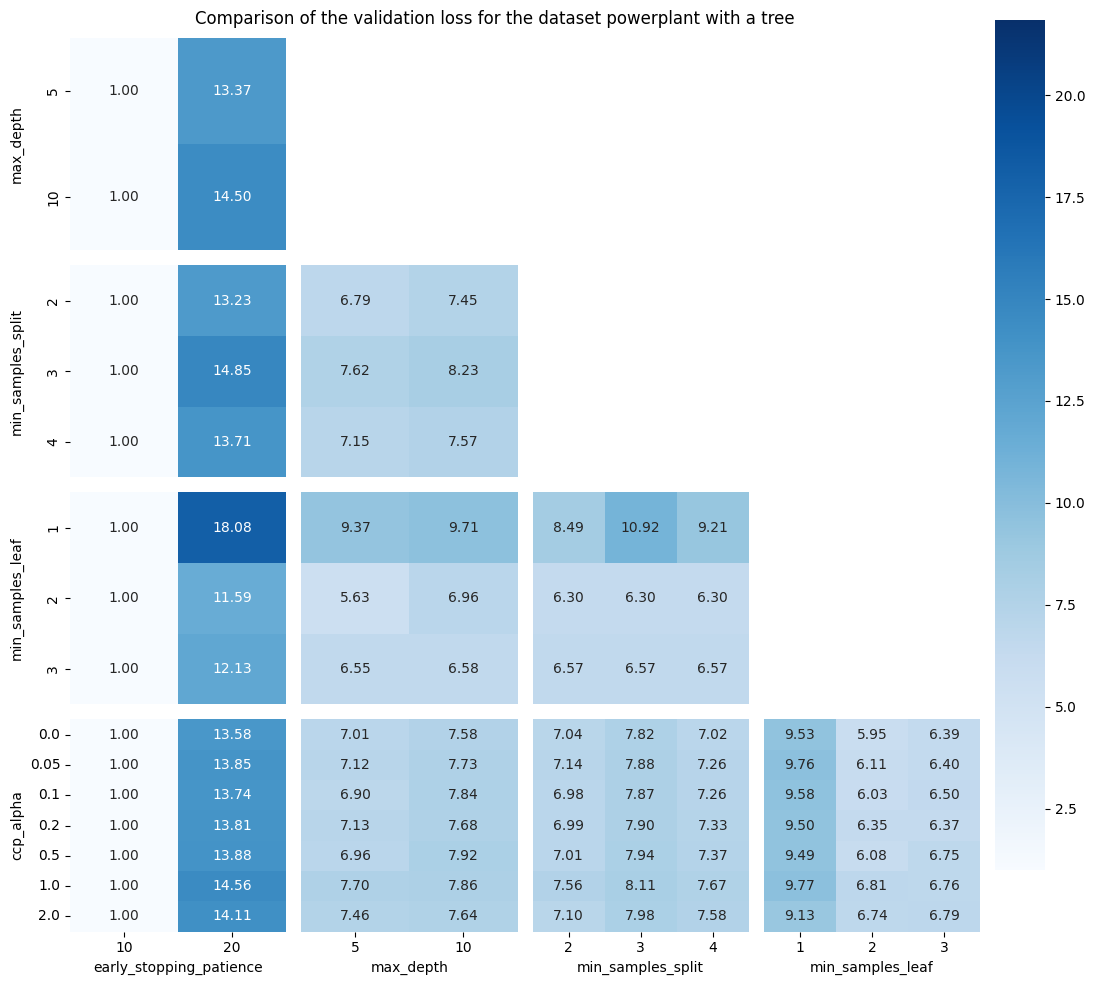

In [84]:
index = 4
mean_arr = results_matrix.mean(1)[index]
key_list = list(hps.keys())[1:]

fig, axs = plt.subplots(len(key_list)-1, len(key_list)-1, figsize=(10,10))
for i in range(0,len(key_list)-1):
    for j in range(i+1,len(key_list)-1):
        fig.delaxes(axs[i, j])

fig.subplots_adjust(right=0.8)

cmap = 'Blues'
vmax = mean_arr.max()
vmin = mean_arr.min()

for i in range(0,len(key_list)-1):
    for j in range(i+1,len(key_list)):
        index_list = list(range(len(key_list)))
        index_list.remove(i)
        index_list.remove(j)
        index_list = index_list[::-1]
        new_arr = mean_arr.mean(index_list[0])
        for k in range(1,len(index_list)):
            new_arr = new_arr.mean(index_list[k])
        df = pd.DataFrame(new_arr.T, index=hps[key_list[j]], columns=hps[key_list[i]])
        if i != 0:
            yticklabels = False
        else:
            yticklabels = True
            axs[j-1,i].set(xlabel=key_list[j])
        if j+1 != len(key_list):
            xticklabels = False
        else:
            xticklabels = True
            axs[j-1,i].set(ylabel=key_list[i])
            
        if j == 1 and i == 0:
            cbar_ax = fig.add_axes([1, 0.12, 0.05, 0.85])
            cbar = True
        else:
            cbar_ax = None
            cbar = False
        
        sn.heatmap(df, annot=True,fmt=".2f", ax=axs[j-1,i], cbar=cbar, vmin=vmin, vmax=vmax,
                cmap=cmap, xticklabels=xticklabels, yticklabels=yticklabels, cbar_ax=cbar_ax)
        if j+1 == len(key_list):
            axs[j-1, i].set(xlabel=key_list[i])
        if i == 0:
            axs[j-1, i].set(ylabel=key_list[j])

fig.suptitle(f"Comparison of the {values_to_fetch[index].replace("_", " ")} for the dataset {dataset} with a {sweep_config}")
# # Layout so plots do not overlap
fig.tight_layout()
fig.align_labels()
plt.savefig(f"./results/trees/{dataset}_{sweep_config}_{values_to_fetch[index]}_heatmaps.jpg", bbox_inches='tight')
print(f"./results/trees/{dataset}_{sweep_config}_{values_to_fetch[index]}_heatmaps.jpg")

/var/folders/t7/t2tk8_dd3vsc811yh2mdwbbh0000gp/T/ipykernel_32473/1206765030.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


./results/trees/powerplant_tree_kl_bound_heatmaps.jpg


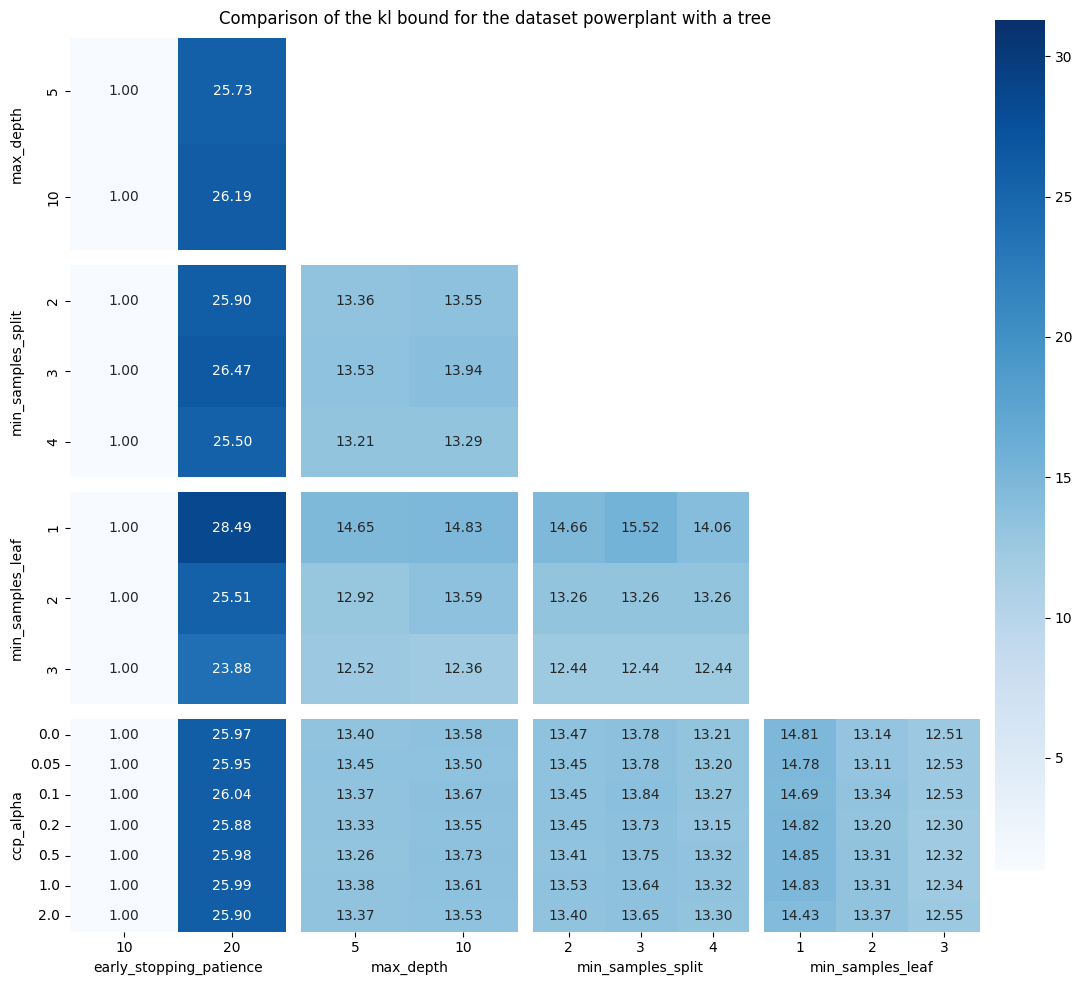

In [85]:
index = 0
mean_arr = results_matrix.mean(1)[index]
key_list = list(hps.keys())[1:]

fig, axs = plt.subplots(len(key_list)-1, len(key_list)-1, figsize=(10,10))
for i in range(0,len(key_list)-1):
    for j in range(i+1,len(key_list)-1):
        fig.delaxes(axs[i, j])

fig.subplots_adjust(right=0.8)

cmap = 'Blues'
vmax = mean_arr.max()
vmin = mean_arr.min()

for i in range(0,len(key_list)-1):
    for j in range(i+1,len(key_list)):
        index_list = list(range(len(key_list)))
        index_list.remove(i)
        index_list.remove(j)
        index_list = index_list[::-1]
        new_arr = mean_arr.mean(index_list[0])
        for k in range(1,len(index_list)):
            new_arr = new_arr.mean(index_list[k])
        df = pd.DataFrame(new_arr.T, index=hps[key_list[j]], columns=hps[key_list[i]])
        if i != 0:
            yticklabels = False
        else:
            yticklabels = True
            axs[j-1,i].set(xlabel=key_list[j])
        if j+1 != len(key_list):
            xticklabels = False
        else:
            xticklabels = True
            axs[j-1,i].set(ylabel=key_list[i])
            
        if j == 1 and i == 0:
            cbar_ax = fig.add_axes([1, 0.12, 0.05, 0.85])
            cbar = True
        else:
            cbar_ax = None
            cbar = False
        
        sn.heatmap(df, annot=True,fmt=".2f", ax=axs[j-1,i], cbar=cbar, vmin=vmin, vmax=vmax,
                cmap=cmap, xticklabels=xticklabels, yticklabels=yticklabels, cbar_ax=cbar_ax)
        if j+1 == len(key_list):
            axs[j-1, i].set(xlabel=key_list[i])
        if i == 0:
            axs[j-1, i].set(ylabel=key_list[j])

fig.suptitle(f"Comparison of the {values_to_fetch[index].replace("_", " ")} for the dataset {dataset} with a {sweep_config}")
# # Layout so plots do not overlap
fig.tight_layout()
fig.align_labels()
plt.savefig(f"./results/trees/{dataset}_{sweep_config}_{values_to_fetch[index]}_heatmaps.jpg", bbox_inches='tight')
print(f"./results/trees/{dataset}_{sweep_config}_{values_to_fetch[index]}_heatmaps.jpg")